# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [3]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score

In [4]:

%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')


In [5]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [6]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [7]:
# Quick check of structure
print("Shape:", df_reviews.shape)
print("Columns:", df_reviews.columns.tolist())
print("\nSample rows:")
display(df_reviews.head())

# Check for missing values
print("\nMissing values per column:")
print(df_reviews.isnull().sum())

# Ensure required columns exist
required_cols = ['review', 'pos', 'ds_part']
for col in required_cols:
    if col not in df_reviews.columns:
        print(f"⚠️ Warning: Column '{col}' not found in dataset!")

# Drop rows where review text is missing
df_reviews = df_reviews.dropna(subset=['review']).reset_index(drop=True)
print("\nAfter dropping rows with missing reviews:", df_reviews.shape)

Shape: (47331, 17)
Columns: ['tconst', 'title_type', 'primary_title', 'original_title', 'start_year', 'end_year', 'runtime_minutes', 'is_adult', 'genres', 'average_rating', 'votes', 'review', 'rating', 'sp', 'pos', 'ds_part', 'idx']

Sample rows:


,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281



Missing values per column:
tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

After dropping rows with missing reviews: (47331, 17)


## EDA

Let's check the number of movies and reviews over years.

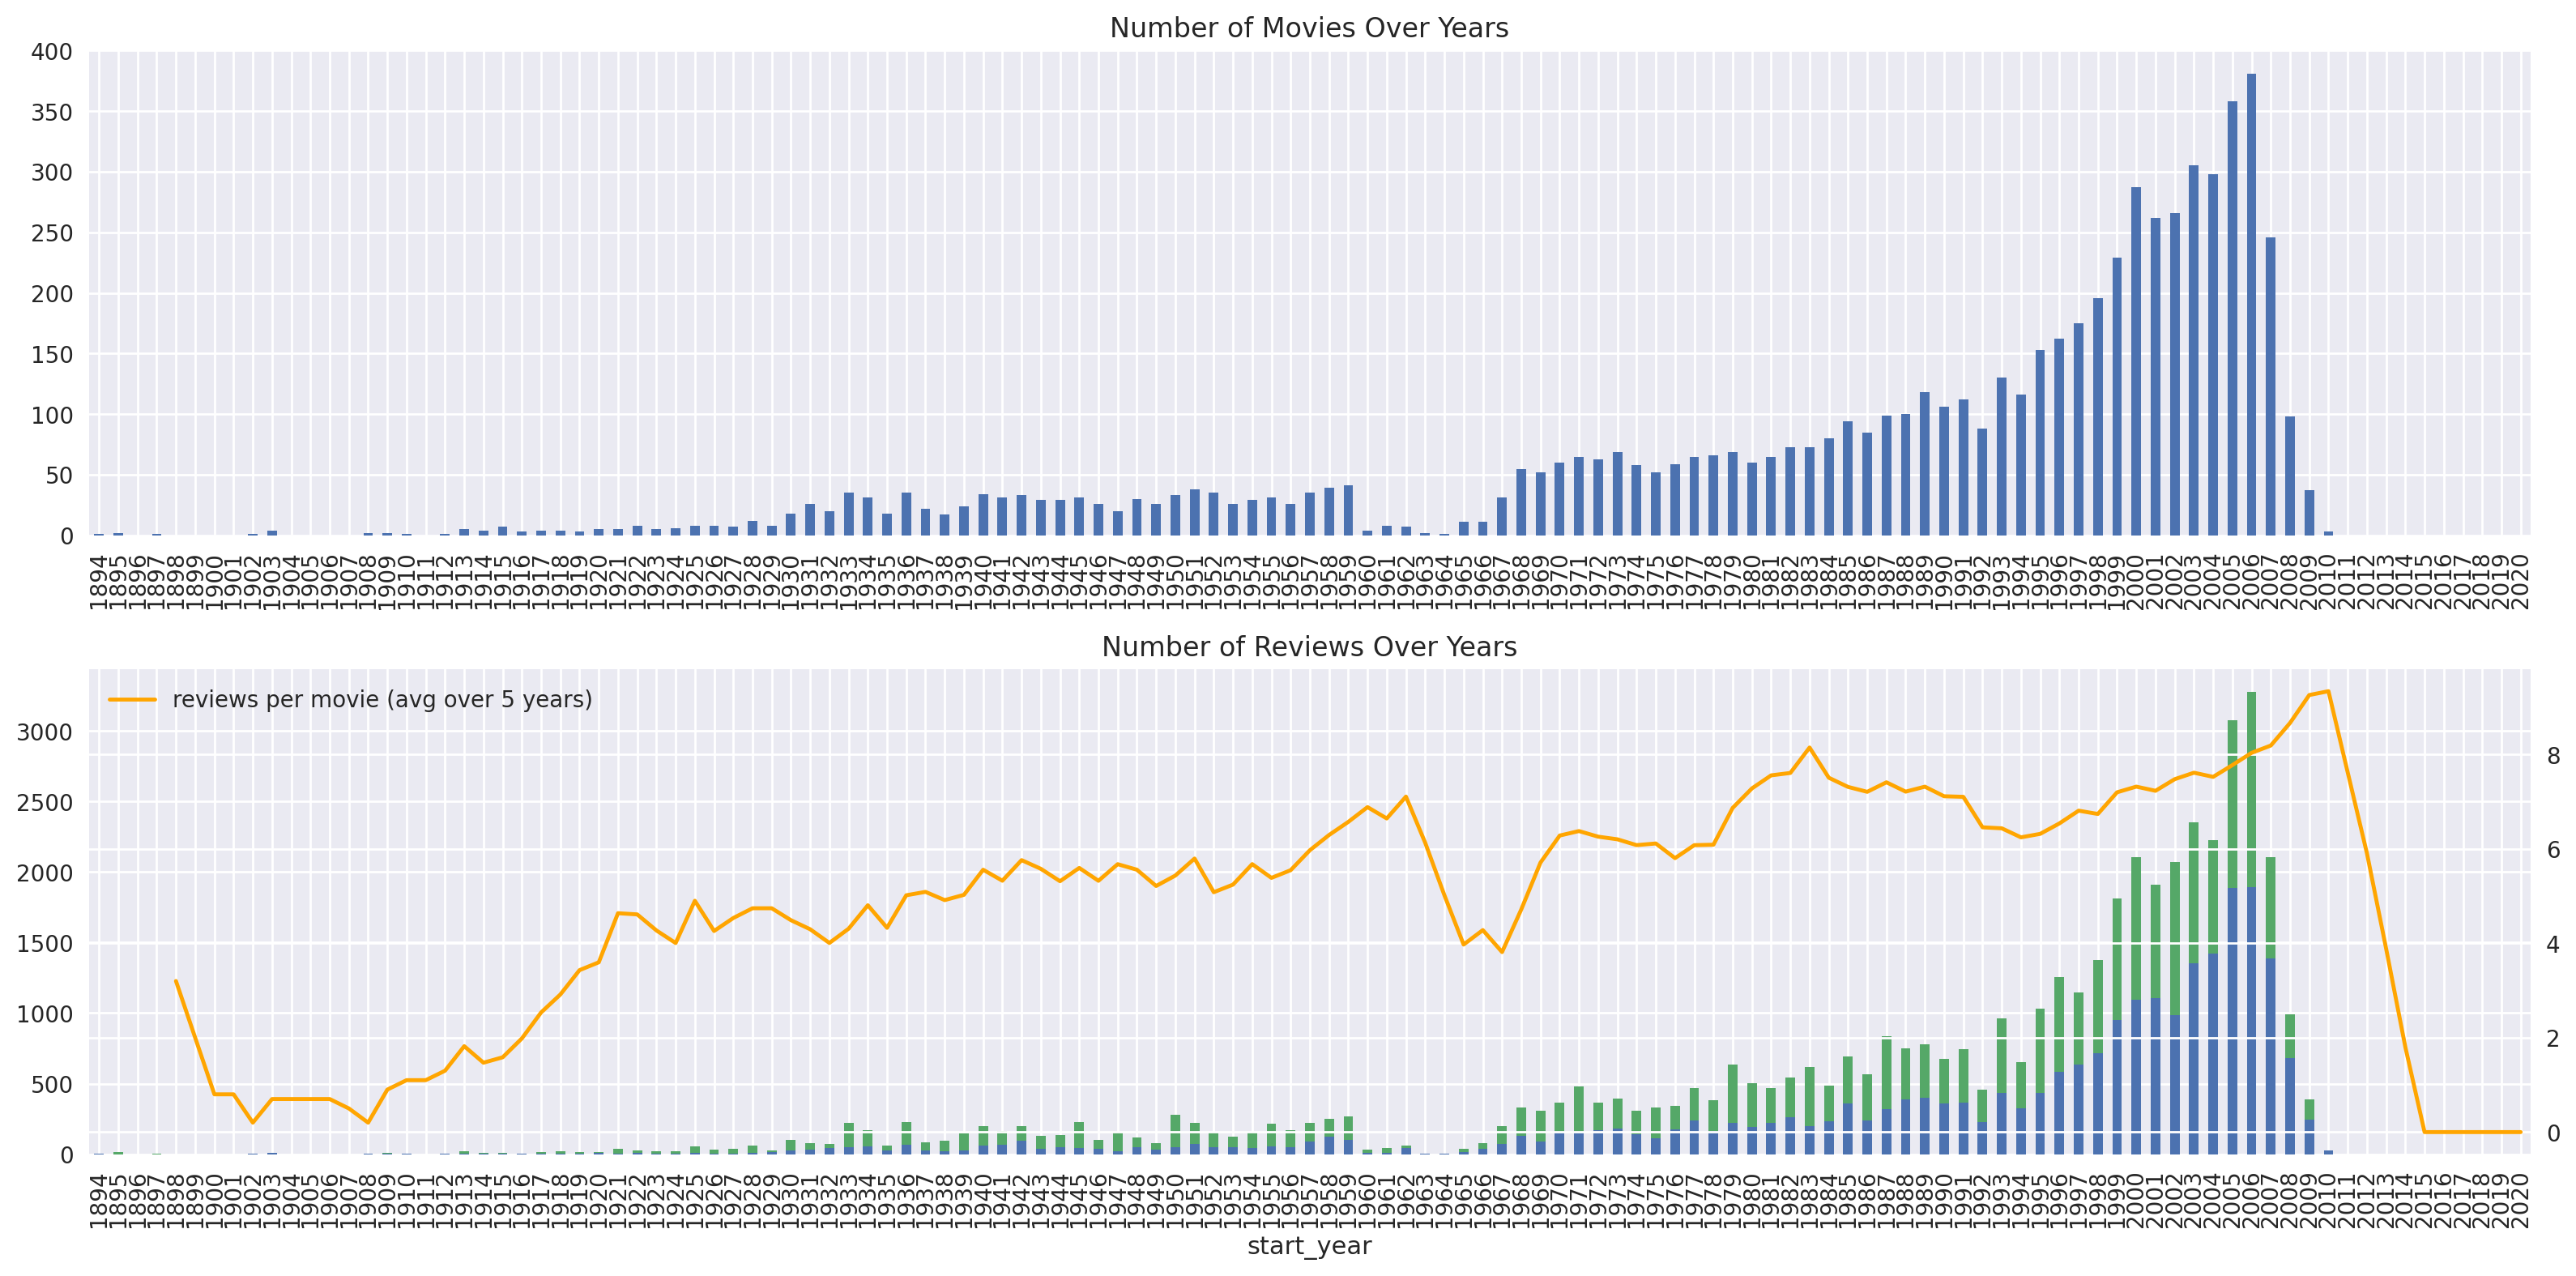

In [8]:

fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()


Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

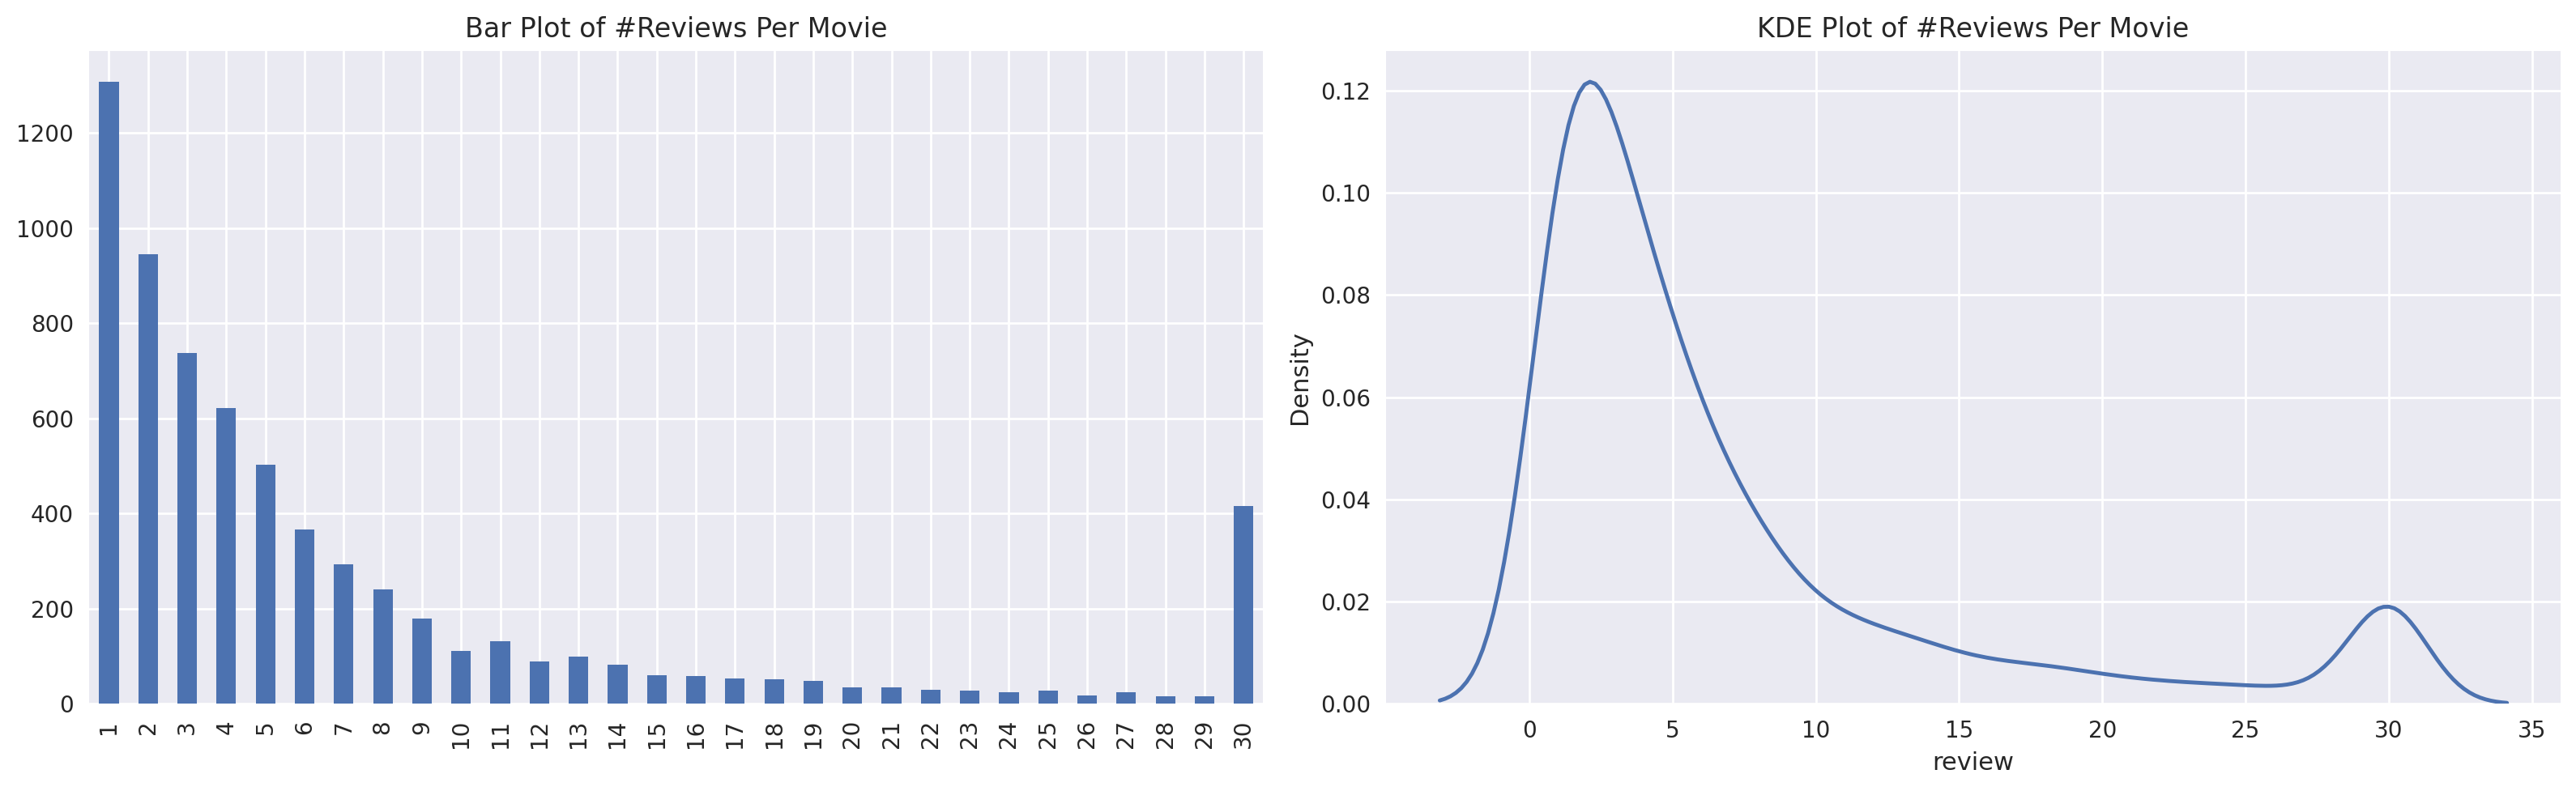

In [9]:

fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()


In [10]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

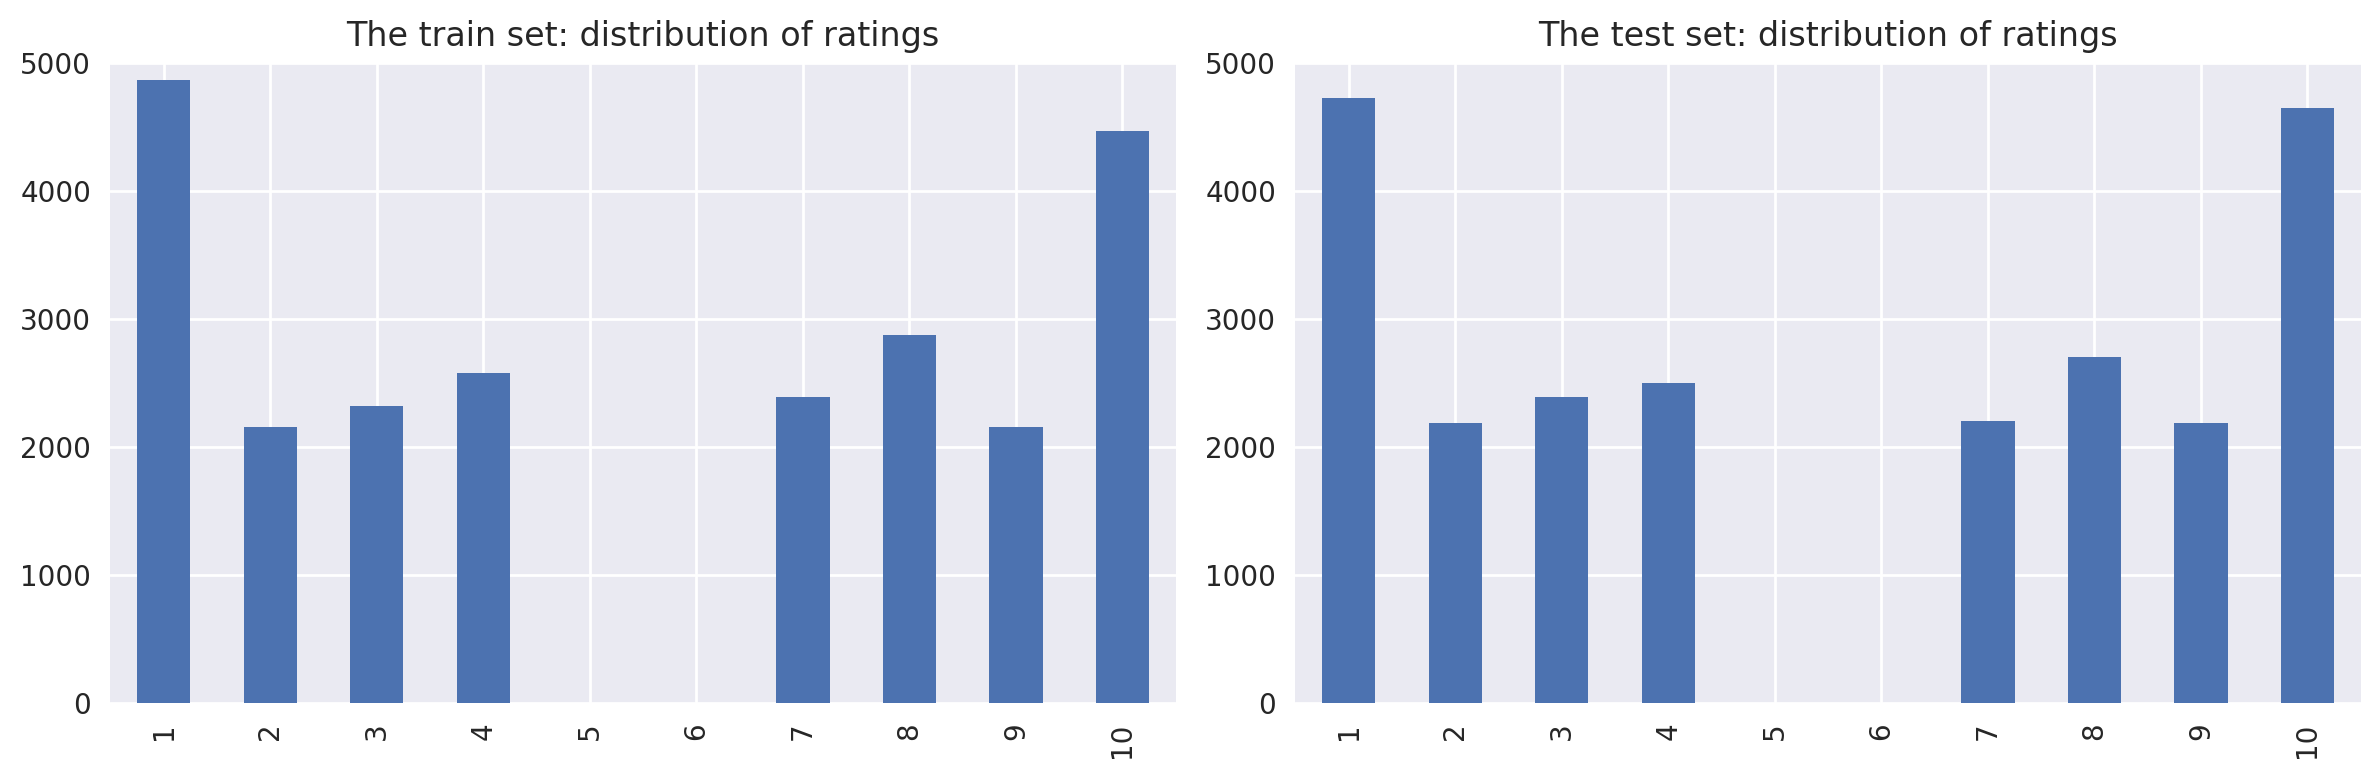

In [11]:

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()


Distribution of negative and positive reviews over the years for two parts of the dataset

/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


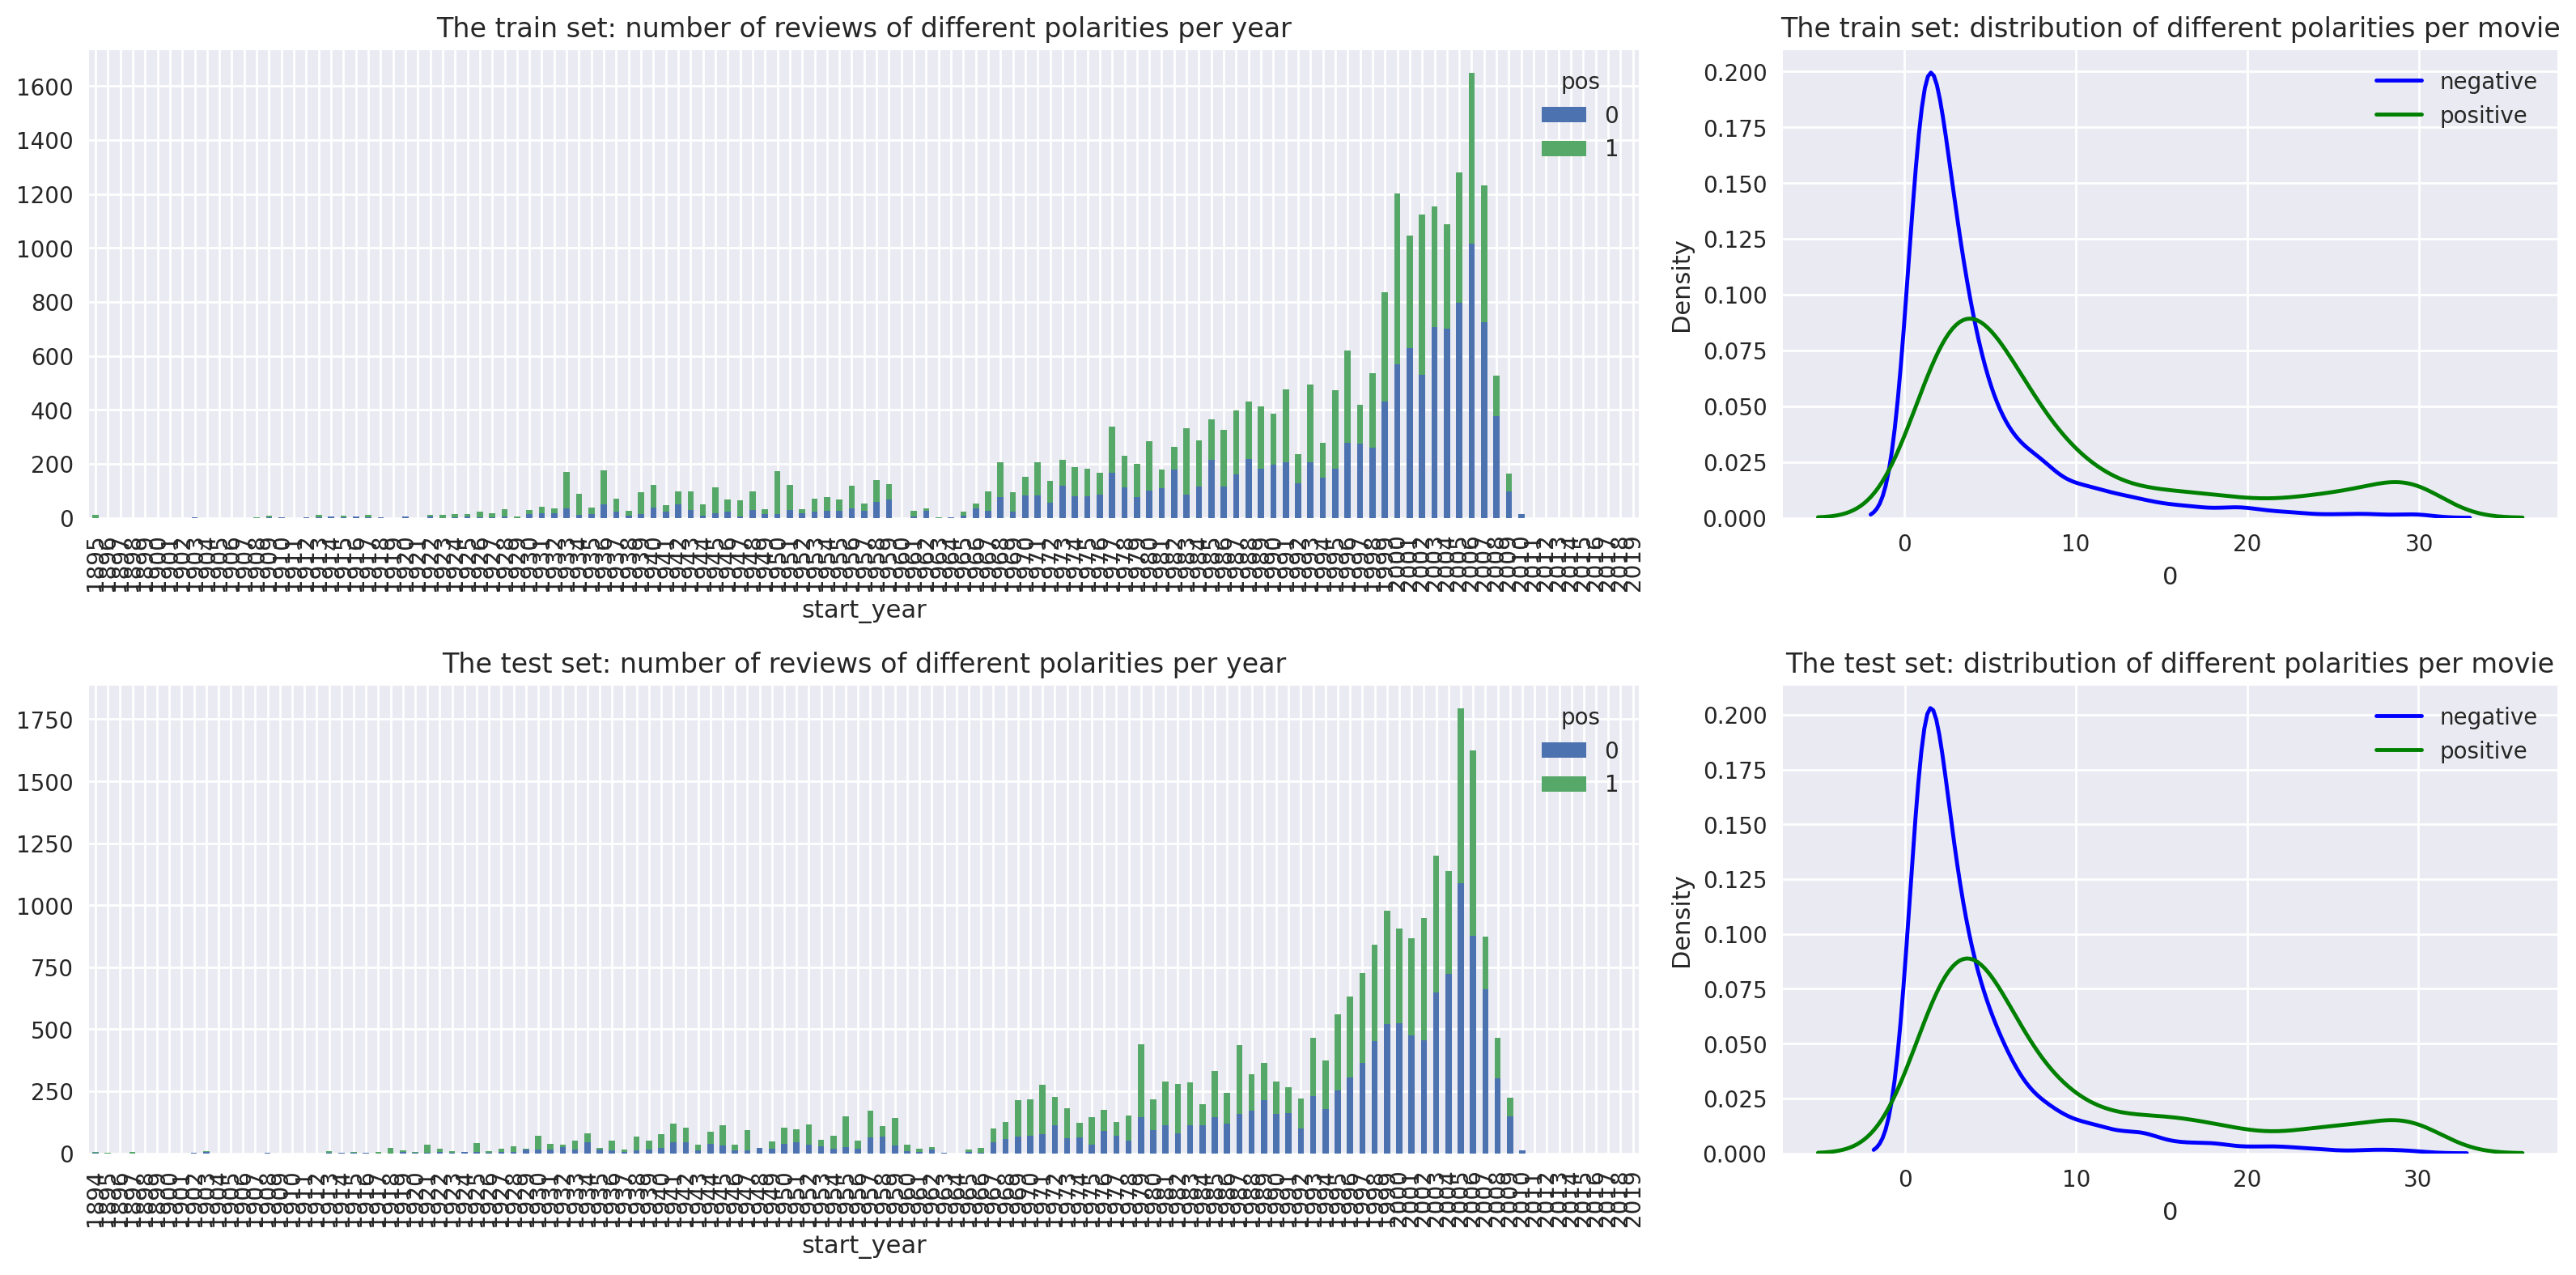

In [12]:

fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()



Class distribution (train):
0    0.500588
1    0.499412
Name: pos, dtype: float64

Class distribution (test):
0    0.501508
1    0.498492
Name: pos, dtype: float64


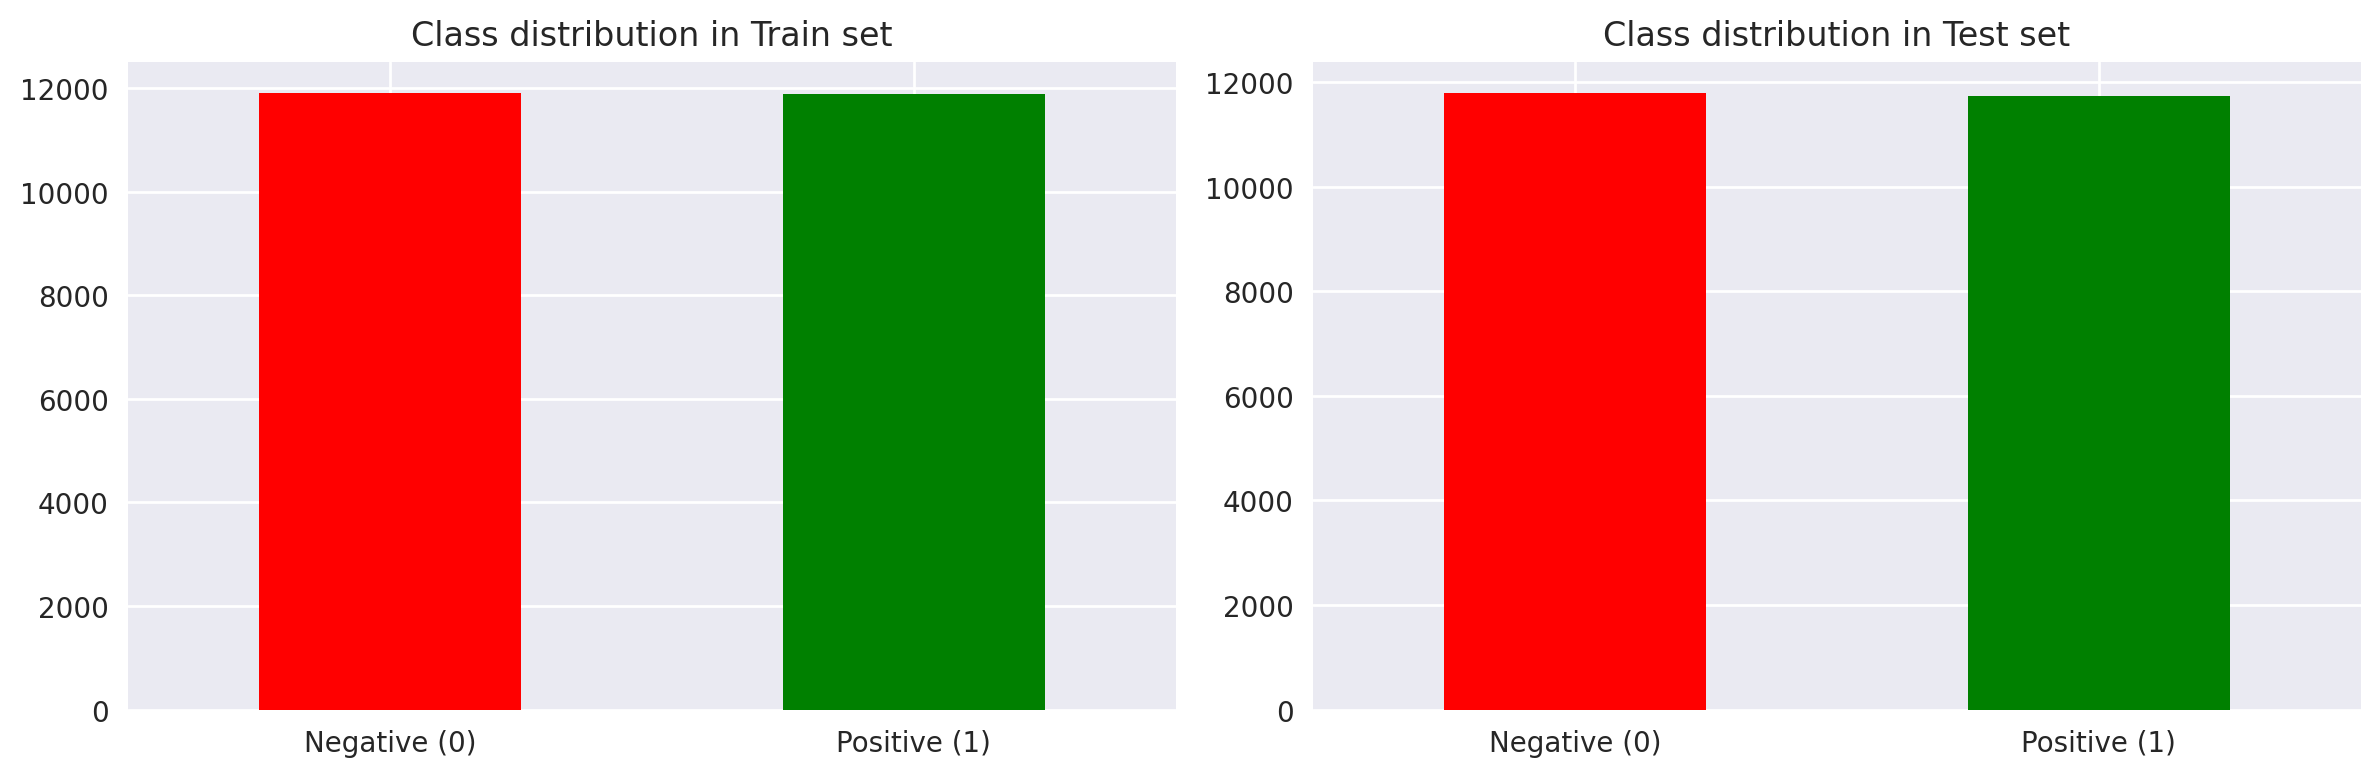

In [13]:
# Check class distribution (train/test separately)
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Train set
df_reviews.query('ds_part == "train"')['pos'].value_counts().plot(
    kind='bar', ax=axs[0], color=['red', 'green'])
axs[0].set_title('Class distribution in Train set')
axs[0].set_xticklabels(['Negative (0)', 'Positive (1)'], rotation=0)

# Test set
df_reviews.query('ds_part == "test"')['pos'].value_counts().plot(
    kind='bar', ax=axs[1], color=['red', 'green'])
axs[1].set_title('Class distribution in Test set')
axs[1].set_xticklabels(['Negative (0)', 'Positive (1)'], rotation=0)

fig.tight_layout()

# Print numeric proportions
print("\nClass distribution (train):")
print(df_reviews.query('ds_part == \"train\"')['pos'].value_counts(normalize=True))

print("\nClass distribution (test):")
print(df_reviews.query('ds_part == \"test\"')['pos'].value_counts(normalize=True))

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [14]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for split, features, target in (('train', train_features, train_target),
                                    ('test', test_features, test_target)):
        
        eval_stats[split] = {}
        
        # Predictions
        pred_target = model.predict(features)
        
        # Handle probabilities (works for LogisticRegression, GradientBoosting, SVC, etc.)
        if hasattr(model, "predict_proba"):
            pred_proba = model.predict_proba(features)[:, 1]
        elif hasattr(model, "decision_function"):
            scores = model.decision_function(features)
            pred_proba = (scores - scores.min()) / (scores.max() - scores.min())  # scale to [0,1]
        else:
            raise ValueError(f"Model {type(model)} does not support probability or decision_function")
        
        # F1 vs thresholds
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba >= thr) for thr in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[split]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[split]['APS'] = aps
        
        # Plotting
        color = 'blue' if split == 'train' else 'green'
        
        # F1 Score curve
        ax = axs[0]
        max_f1_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color,
                label=f'{split}, max={f1_scores[max_f1_idx]:.2f} @ {f1_thresholds[max_f1_idx]:.2f}')
        for thr in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest = np.argmin(np.abs(f1_thresholds - thr))
            marker_color = 'orange' if thr != 0.5 else 'red'
            ax.plot(f1_thresholds[closest], f1_scores[closest],
                    color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02]); ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold'); ax.set_ylabel('F1')
        ax.legend(loc='lower center'); ax.set_title('F1 Score') 

        # ROC Curve
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{split}, AUC={roc_auc:.2f}')
        for thr in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest = np.argmin(np.abs(roc_thresholds - thr))
            marker_color = 'orange' if thr != 0.5 else 'red'
            ax.plot(fpr[closest], tpr[closest], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02]); ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR'); ax.set_ylabel('TPR')
        ax.legend(loc='lower center'); ax.set_title('ROC Curve')

        # Precision-Recall Curve
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{split}, AP={aps:.2f}')
        for thr in (0.2, 0.4, 0.5, 0.6, 0.8):
            if len(pr_thresholds) > 0:
                closest = np.argmin(np.abs(pr_thresholds - thr))
                marker_color = 'orange' if thr != 0.5 else 'red'
                ax.plot(recall[closest], precision[closest],
                        color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02]); ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall'); ax.set_ylabel('precision')
        ax.legend(loc='lower center'); ax.set_title('PRC')        

        # Summary metrics
        eval_stats[split]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[split]['F1'] = metrics.f1_score(target, pred_target)
        eval_stats[split]['F1 (neg)'] = metrics.f1_score(target, pred_target, pos_label=0)
        eval_stats[split]['F1 (pos)'] = metrics.f1_score(target, pred_target, pos_label=1)
    
    # Display summary table
    df_eval_stats = pd.DataFrame(eval_stats).round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'F1 (neg)', 'F1 (pos)', 'APS', 'ROC AUC'))
    print(df_eval_stats)
    
    # Confusion matrices
    fig_cm, axs_cm = plt.subplots(1, 2, figsize=(12, 5))
    for idx, (split, features, target) in enumerate((('train', train_features, train_target),
                                                 ('test', test_features, test_target))):
        pred_target = model.predict(features)
        cm = confusion_matrix(target, pred_target)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
        disp.plot(cmap='Blues', ax=axs_cm[idx], values_format='d', colorbar=False)
        axs_cm[idx].set_title(f'Confusion Matrix ({split})')
    plt.tight_layout()
    
    return df_eval_stats

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [15]:
import re

def normalize_text(text):
    """Lowercase, remove digits, punctuation, and extra spaces."""
    if not isinstance(text, str):
        return ""
    text = text.lower()                           
    text = re.sub(r"[^a-z\s]", " ", text)         
    text = re.sub(r"\s+", " ", text).strip()      
    return text

df_reviews['review_norm'] = df_reviews['review'].progress_apply(normalize_text)

df_reviews[['review', 'review_norm']].head()

  0%|          | 0/47331 [00:00<?, ?it/s]

,review,review_norm
0,The pakage implies that Warren Beatty and Gold...,the pakage implies that warren beatty and gold...
1,How the hell did they get this made?! Presenti...,how the hell did they get this made presenting...
2,There is no real story the film seems more lik...,there is no real story the film seems more lik...
3,Um .... a serious film about troubled teens in...,um a serious film about troubled teens in sing...
4,I'm totally agree with GarryJohal from Singapo...,i m totally agree with garryjohal from singapo...


## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [16]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

# Define features (normalized reviews) and targets (labels)
train_texts = df_reviews_train['review_norm']
test_texts = df_reviews_test['review_norm']

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print("Train shape:", df_reviews_train.shape)
print("Test shape:", df_reviews_test.shape)

# Check label distribution
print("\nLabel distribution in Train set:")
print(train_target.value_counts(normalize=True))

print("\nLabel distribution in Test set:")
print(test_target.value_counts(normalize=True))

Train shape: (23796, 18)
Test shape: (23535, 18)

Label distribution in Train set:
0    0.500588
1    0.499412
Name: pos, dtype: float64

Label distribution in Test set:
0    0.501508
1    0.498492
Name: pos, dtype: float64


## Working with models

### Model 0 - Constant

In [17]:
from sklearn.dummy import DummyClassifier
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


          train  test
Accuracy   0.50  0.50
F1         0.00  0.00
F1 (neg)   0.67  0.67
F1 (pos)   0.00  0.00
APS        0.50  0.50
ROC AUC    0.50  0.50


,train,test
Accuracy,0.50,0.50
F1,0.00,0.00
F1 (neg),0.67,0.67
F1 (pos),0.00,0.00
APS,0.50,0.50
ROC AUC,0.50,0.50


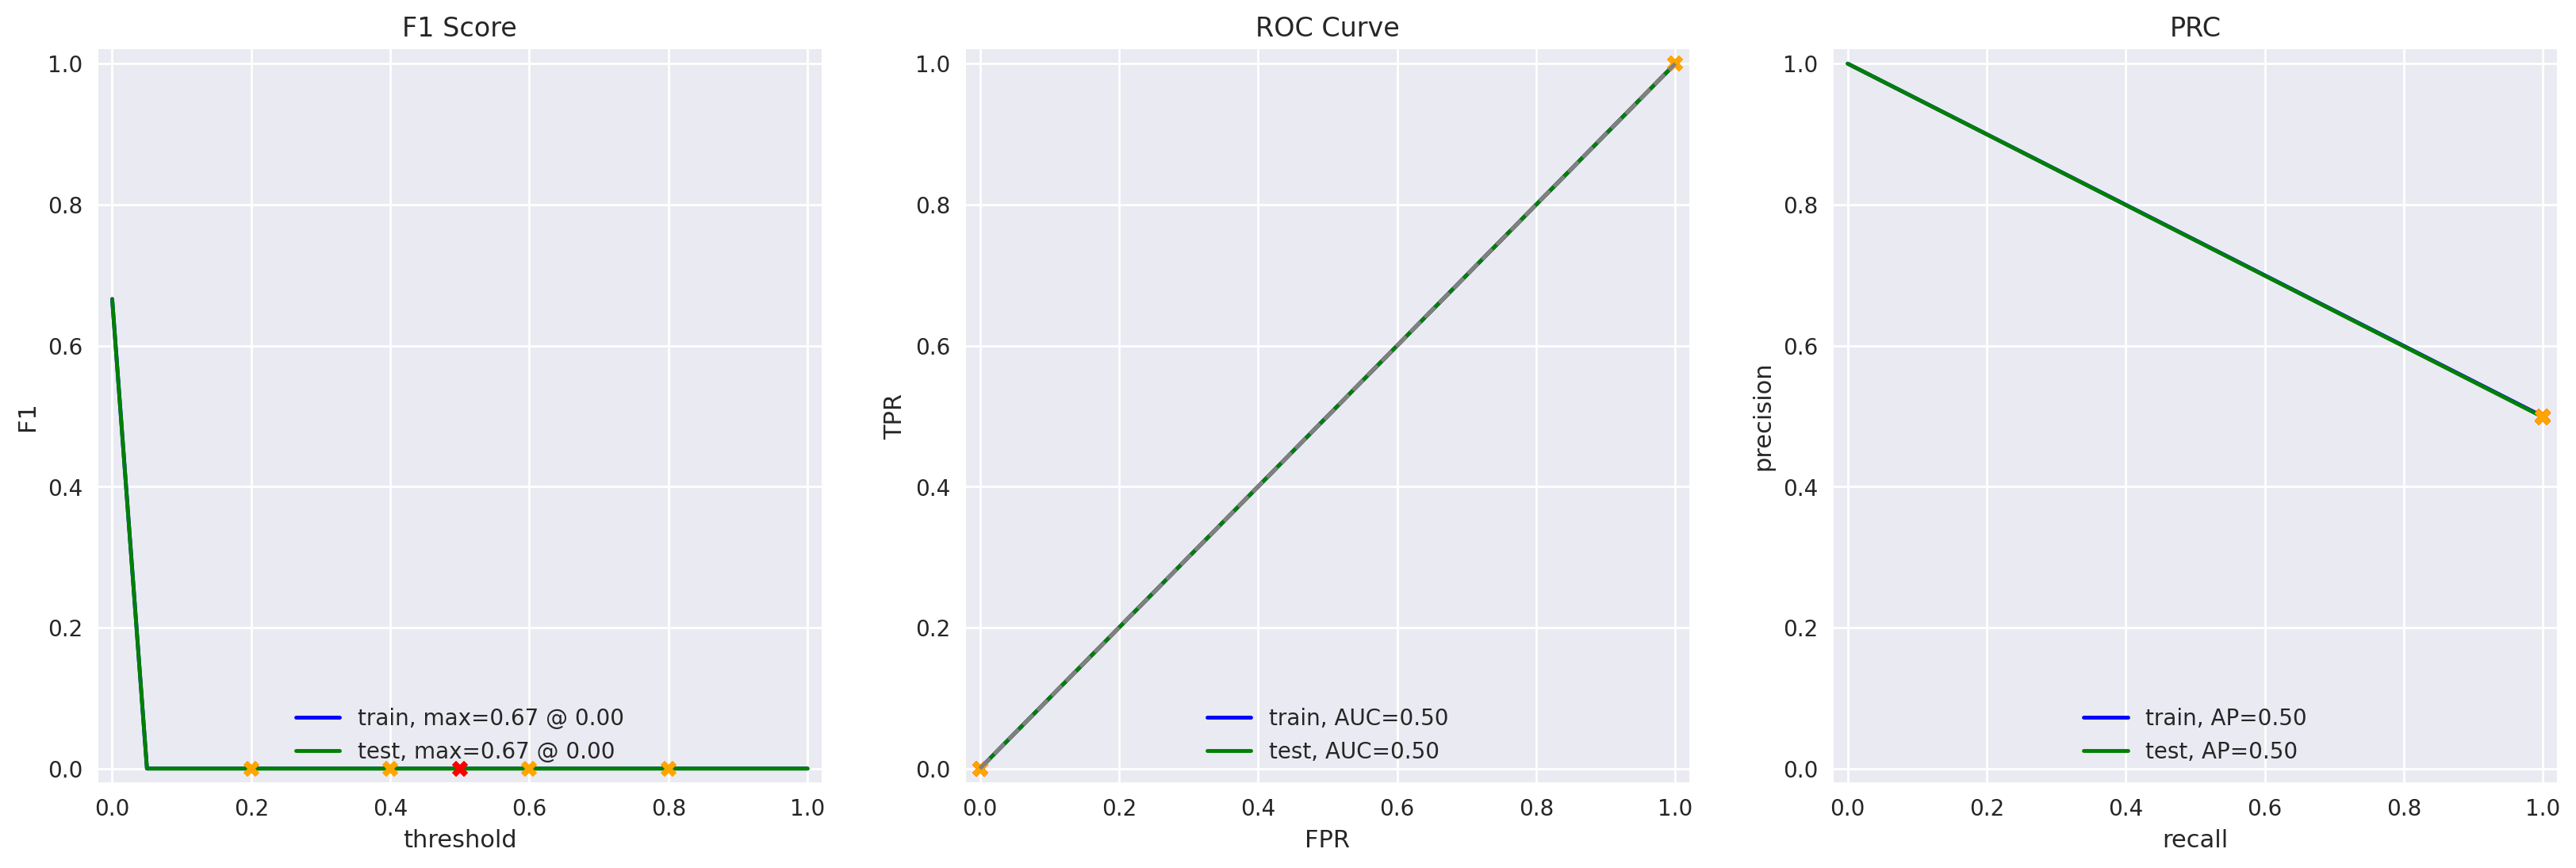

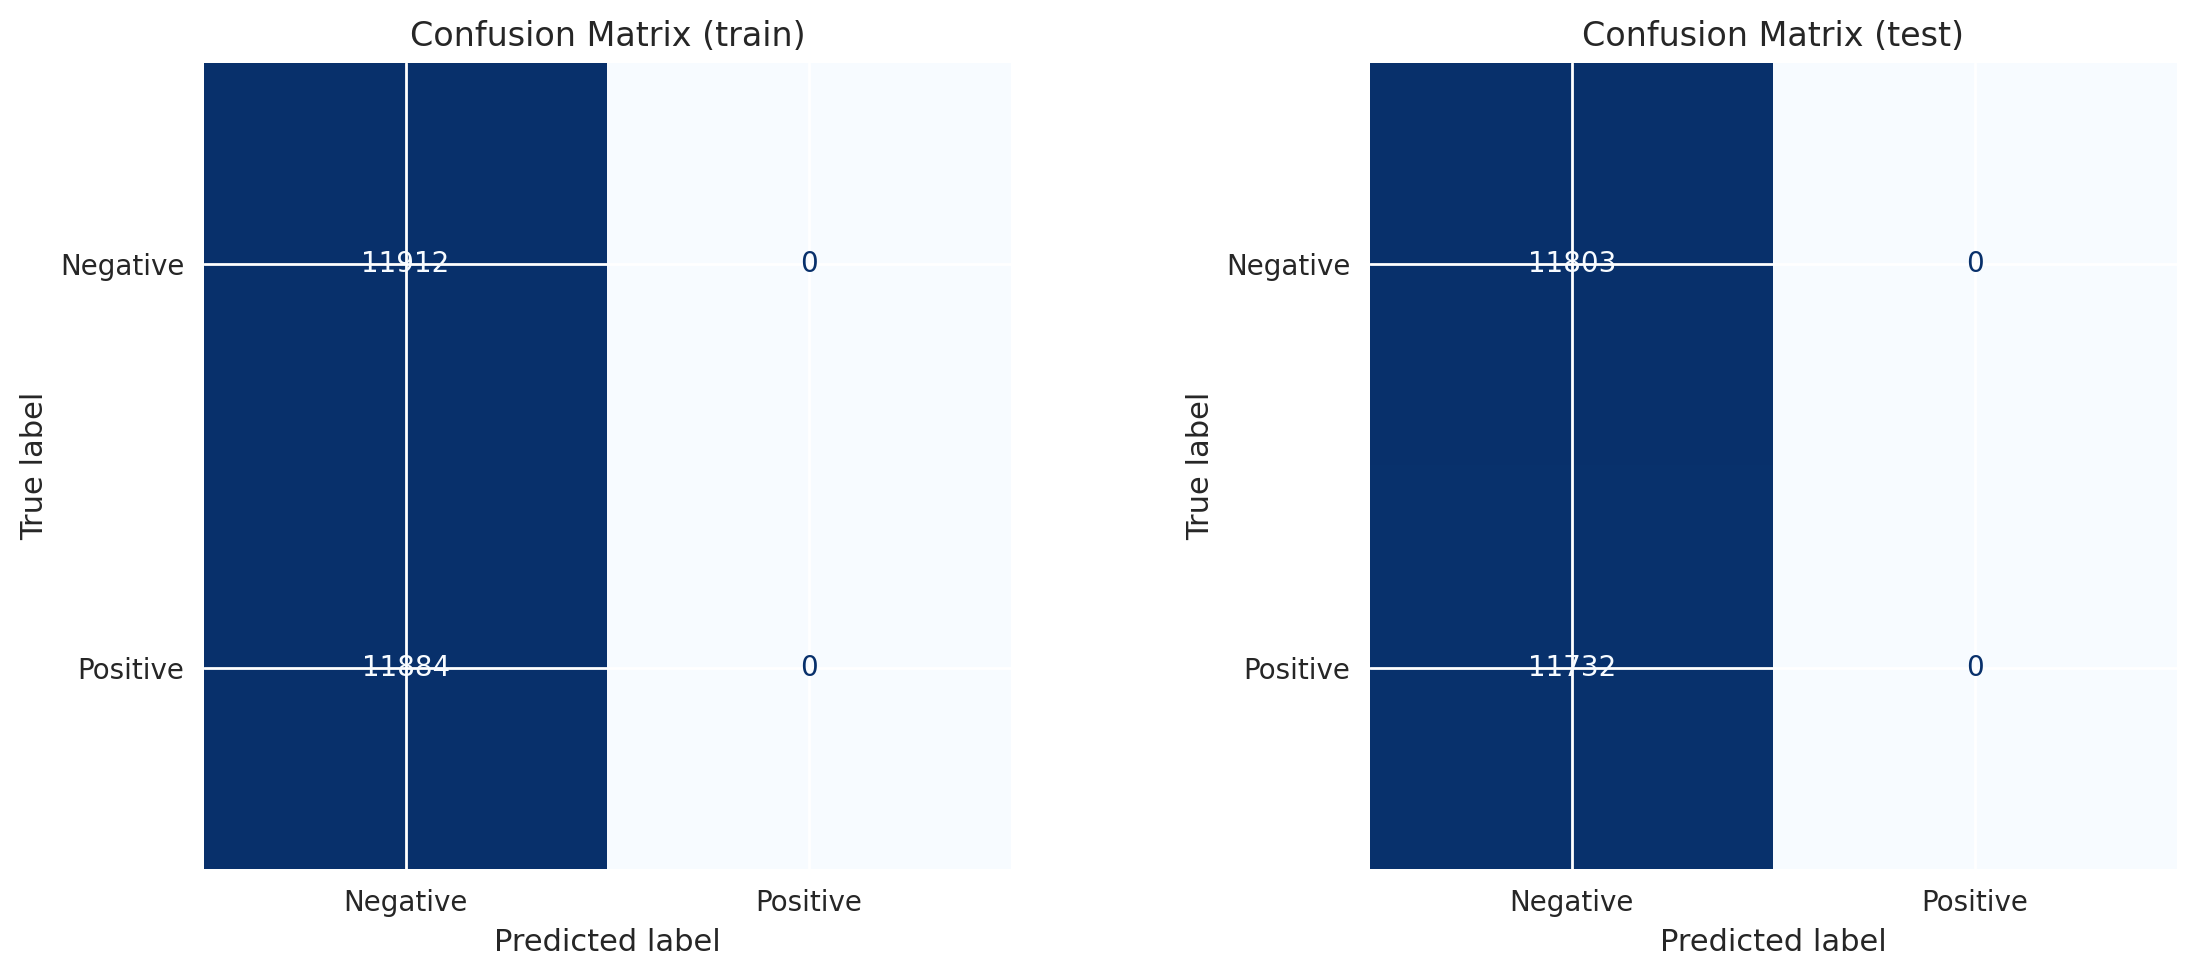

In [18]:
# Train constant baseline model (always predicts majority class)
model_0 = DummyClassifier(strategy='most_frequent')
model_0.fit(train_texts, train_target)  # needs features, but will ignore them

# Evaluate
evaluate_model(model_0, train_texts, train_target, test_texts, test_target)

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [19]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/student/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


          train  test
Accuracy   0.94  0.89
F1         0.94  0.89
F1 (neg)   0.94  0.89
F1 (pos)   0.94  0.89
APS        0.98  0.95
ROC AUC    0.98  0.96


,train,test
Accuracy,0.94,0.89
F1,0.94,0.89
F1 (neg),0.94,0.89
F1 (pos),0.94,0.89
APS,0.98,0.95
ROC AUC,0.98,0.96


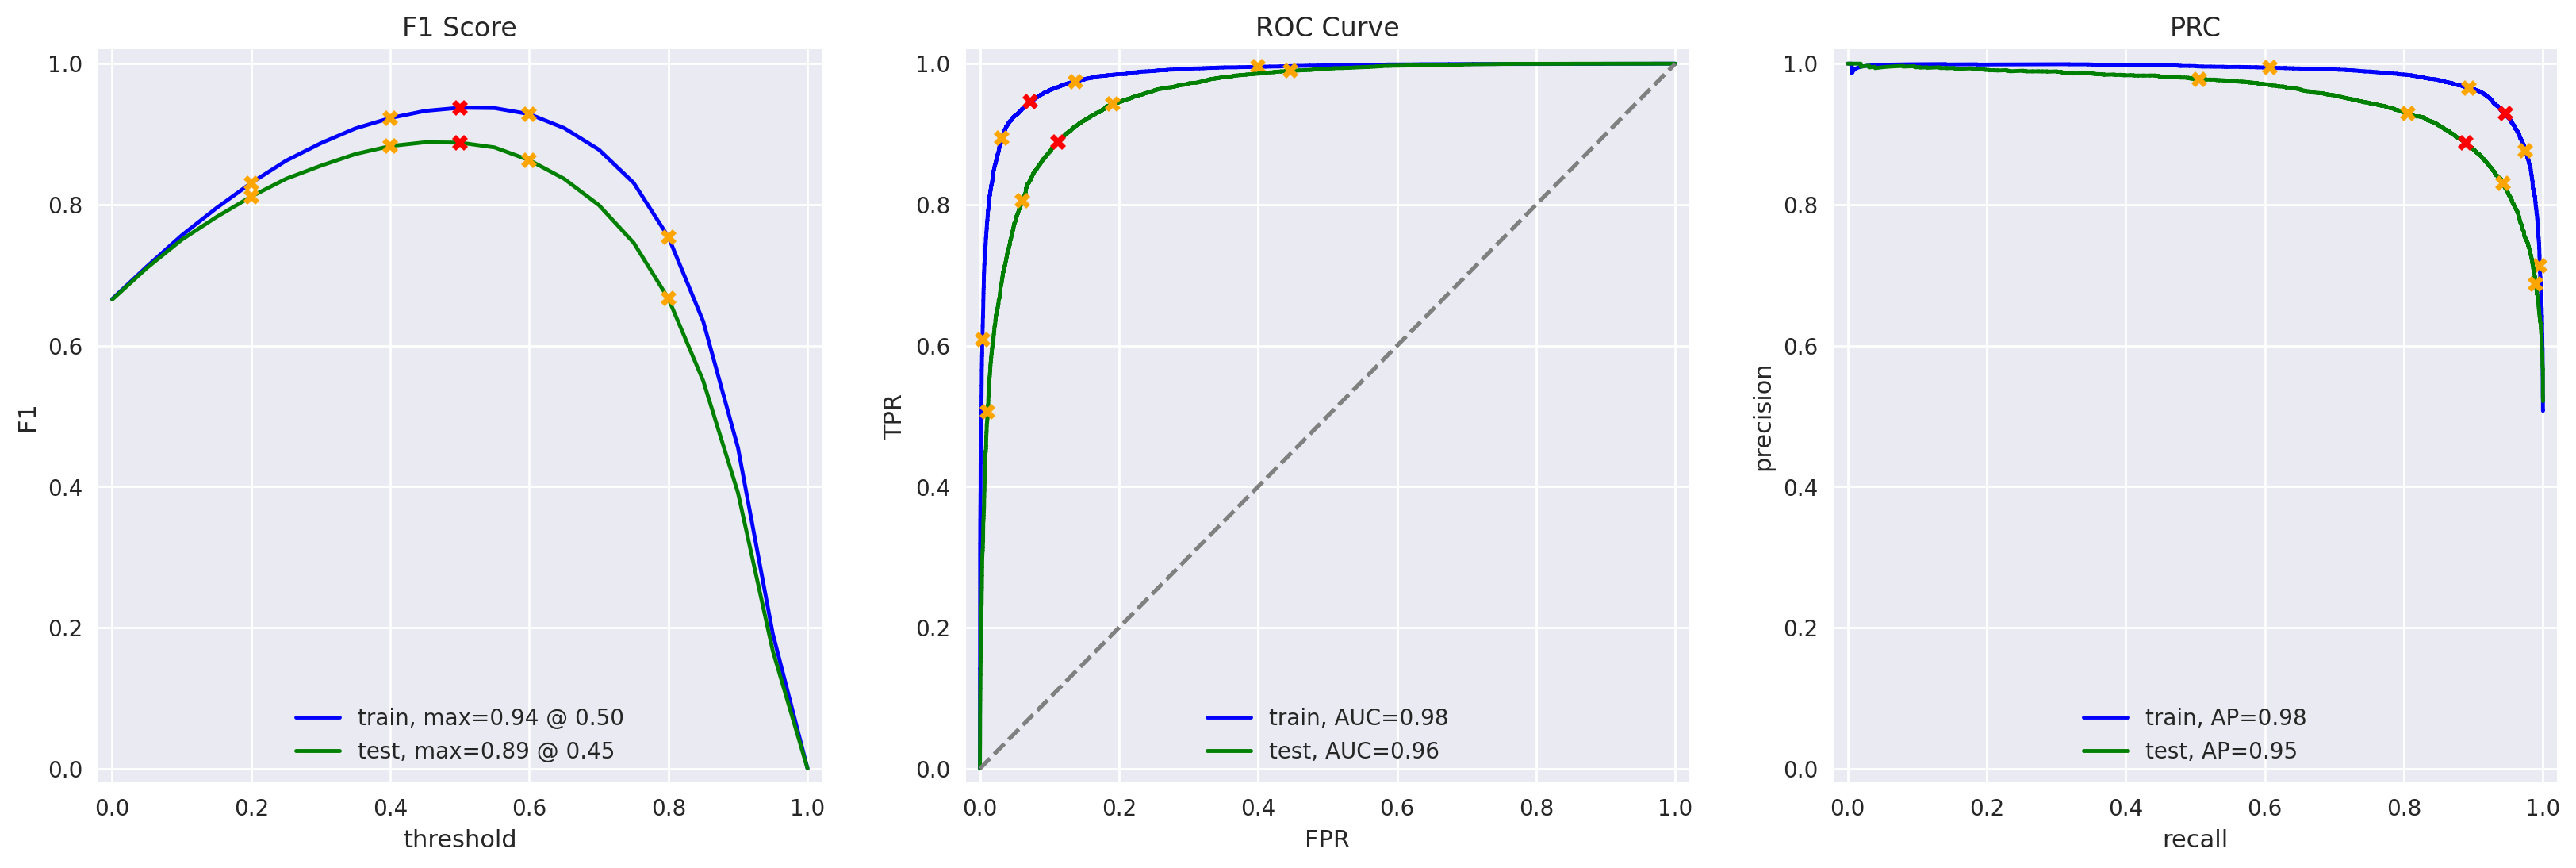

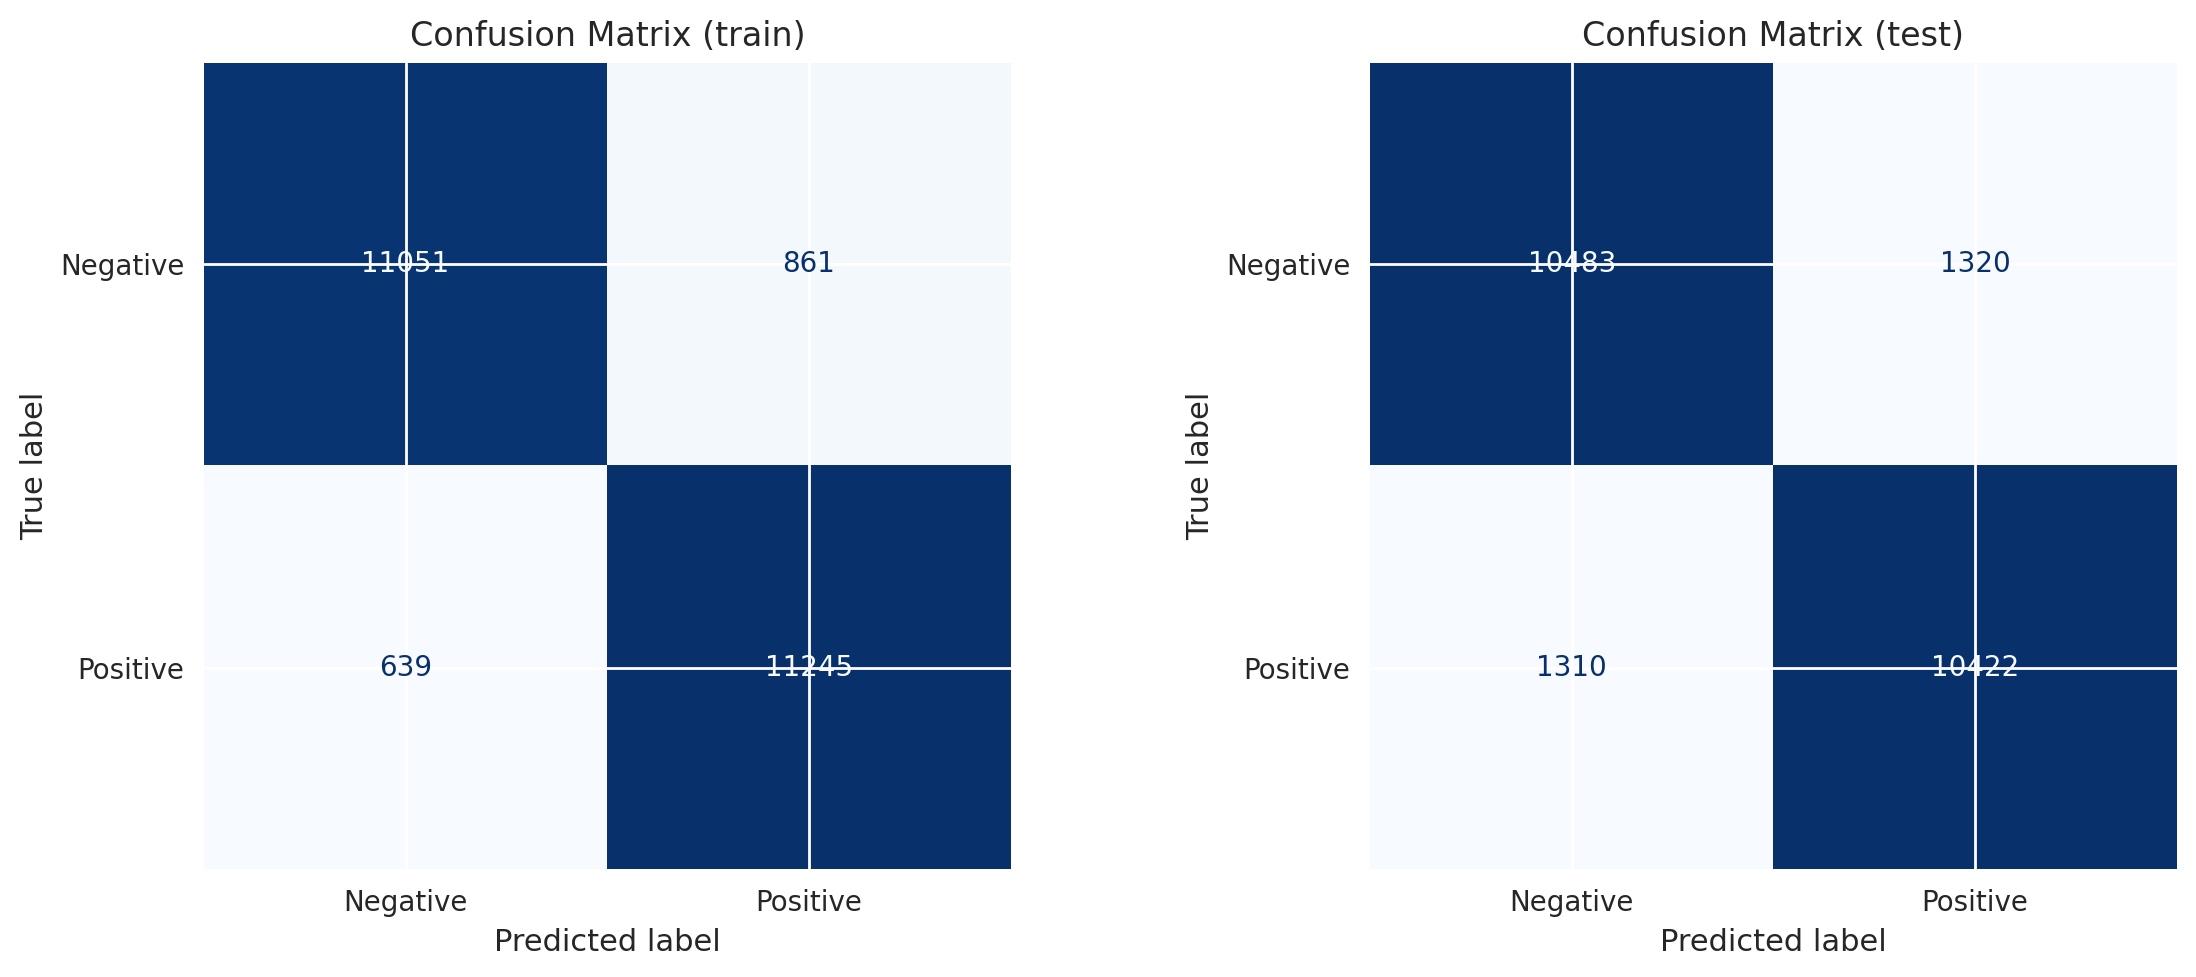

In [20]:
# Ensure stopwords are downloaded
nltk.download('stopwords')
stop_words = stopwords.words('english')

# TF-IDF vectorization
vectorizer_1 = TfidfVectorizer(stop_words=stop_words, max_features=20000, ngram_range=(1,2))
train_features_1 = vectorizer_1.fit_transform(train_texts)
test_features_1 = vectorizer_1.transform(test_texts)

# Logistic Regression
model_1 = LogisticRegression(max_iter=200, class_weight='balanced')
model_1.fit(train_features_1, train_target)

# Evaluate
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

### Model 3 - spaCy, TF-IDF and LR

In [21]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [22]:

def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)


  0%|          | 0/23796 [00:00<?, ?it/s]

  0%|          | 0/23535 [00:00<?, ?it/s]

          train  test
Accuracy   0.93  0.89
F1         0.93  0.89
F1 (neg)   0.93  0.89
F1 (pos)   0.93  0.89
APS        0.98  0.96
ROC AUC    0.98  0.96


,train,test
Accuracy,0.93,0.89
F1,0.93,0.89
F1 (neg),0.93,0.89
F1 (pos),0.93,0.89
APS,0.98,0.96
ROC AUC,0.98,0.96


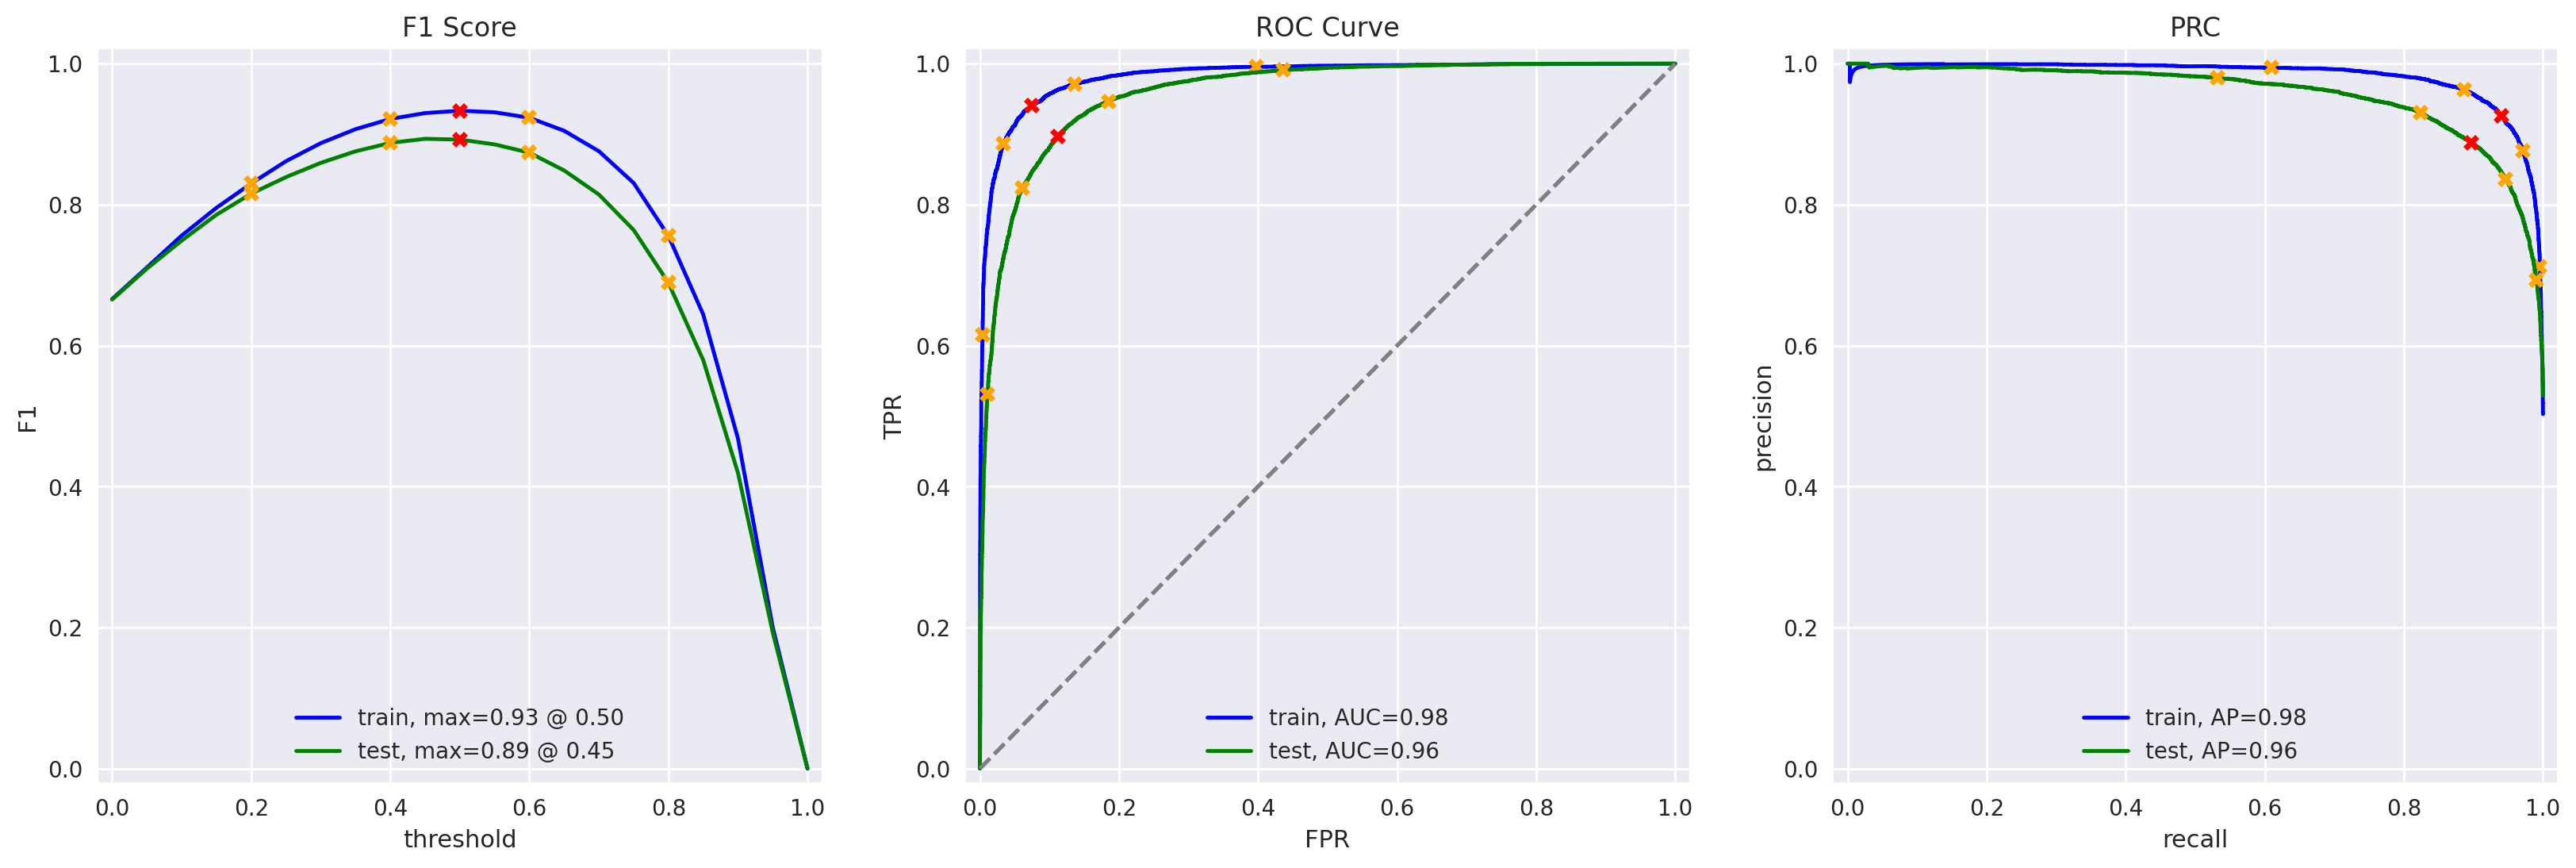

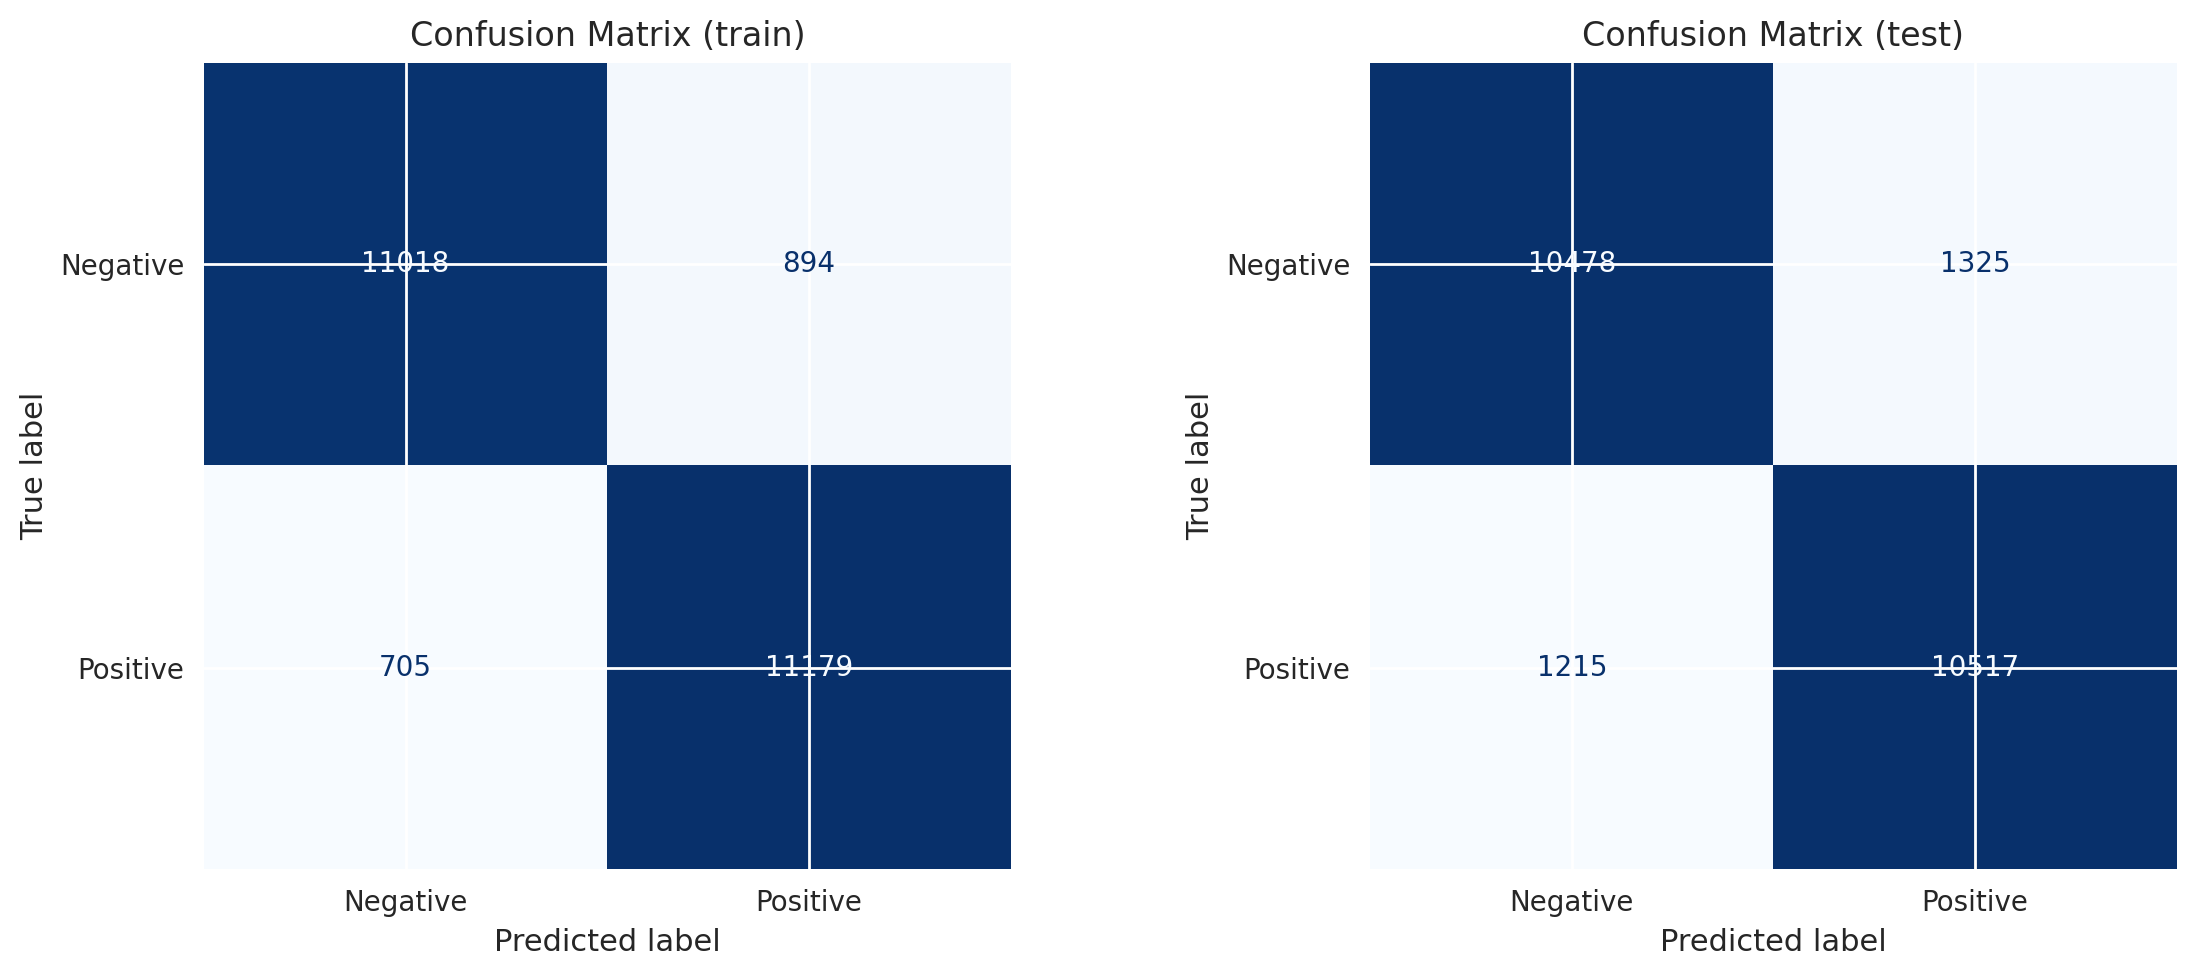

In [23]:
# Apply preprocessing
train_texts_3 = df_reviews_train['review_norm'].progress_apply(text_preprocessing_3)
test_texts_3 = df_reviews_test['review_norm'].progress_apply(text_preprocessing_3)

# TF-IDF
vectorizer_3 = TfidfVectorizer(max_features=20000, ngram_range=(1,2))
train_features_3 = vectorizer_3.fit_transform(train_texts_3)
test_features_3 = vectorizer_3.transform(test_texts_3)

# Logistic Regression
model_3 = LogisticRegression(max_iter=200, class_weight='balanced')
model_3.fit(train_features_3, train_target)

# Evaluate
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [24]:
from lightgbm import LGBMClassifier

          train  test
Accuracy   0.97  0.88
F1         0.97  0.88
F1 (neg)   0.97  0.88
F1 (pos)   0.97  0.88
APS        1.00  0.95
ROC AUC    1.00  0.95


,train,test
Accuracy,0.97,0.88
F1,0.97,0.88
F1 (neg),0.97,0.88
F1 (pos),0.97,0.88
APS,1.00,0.95
ROC AUC,1.00,0.95


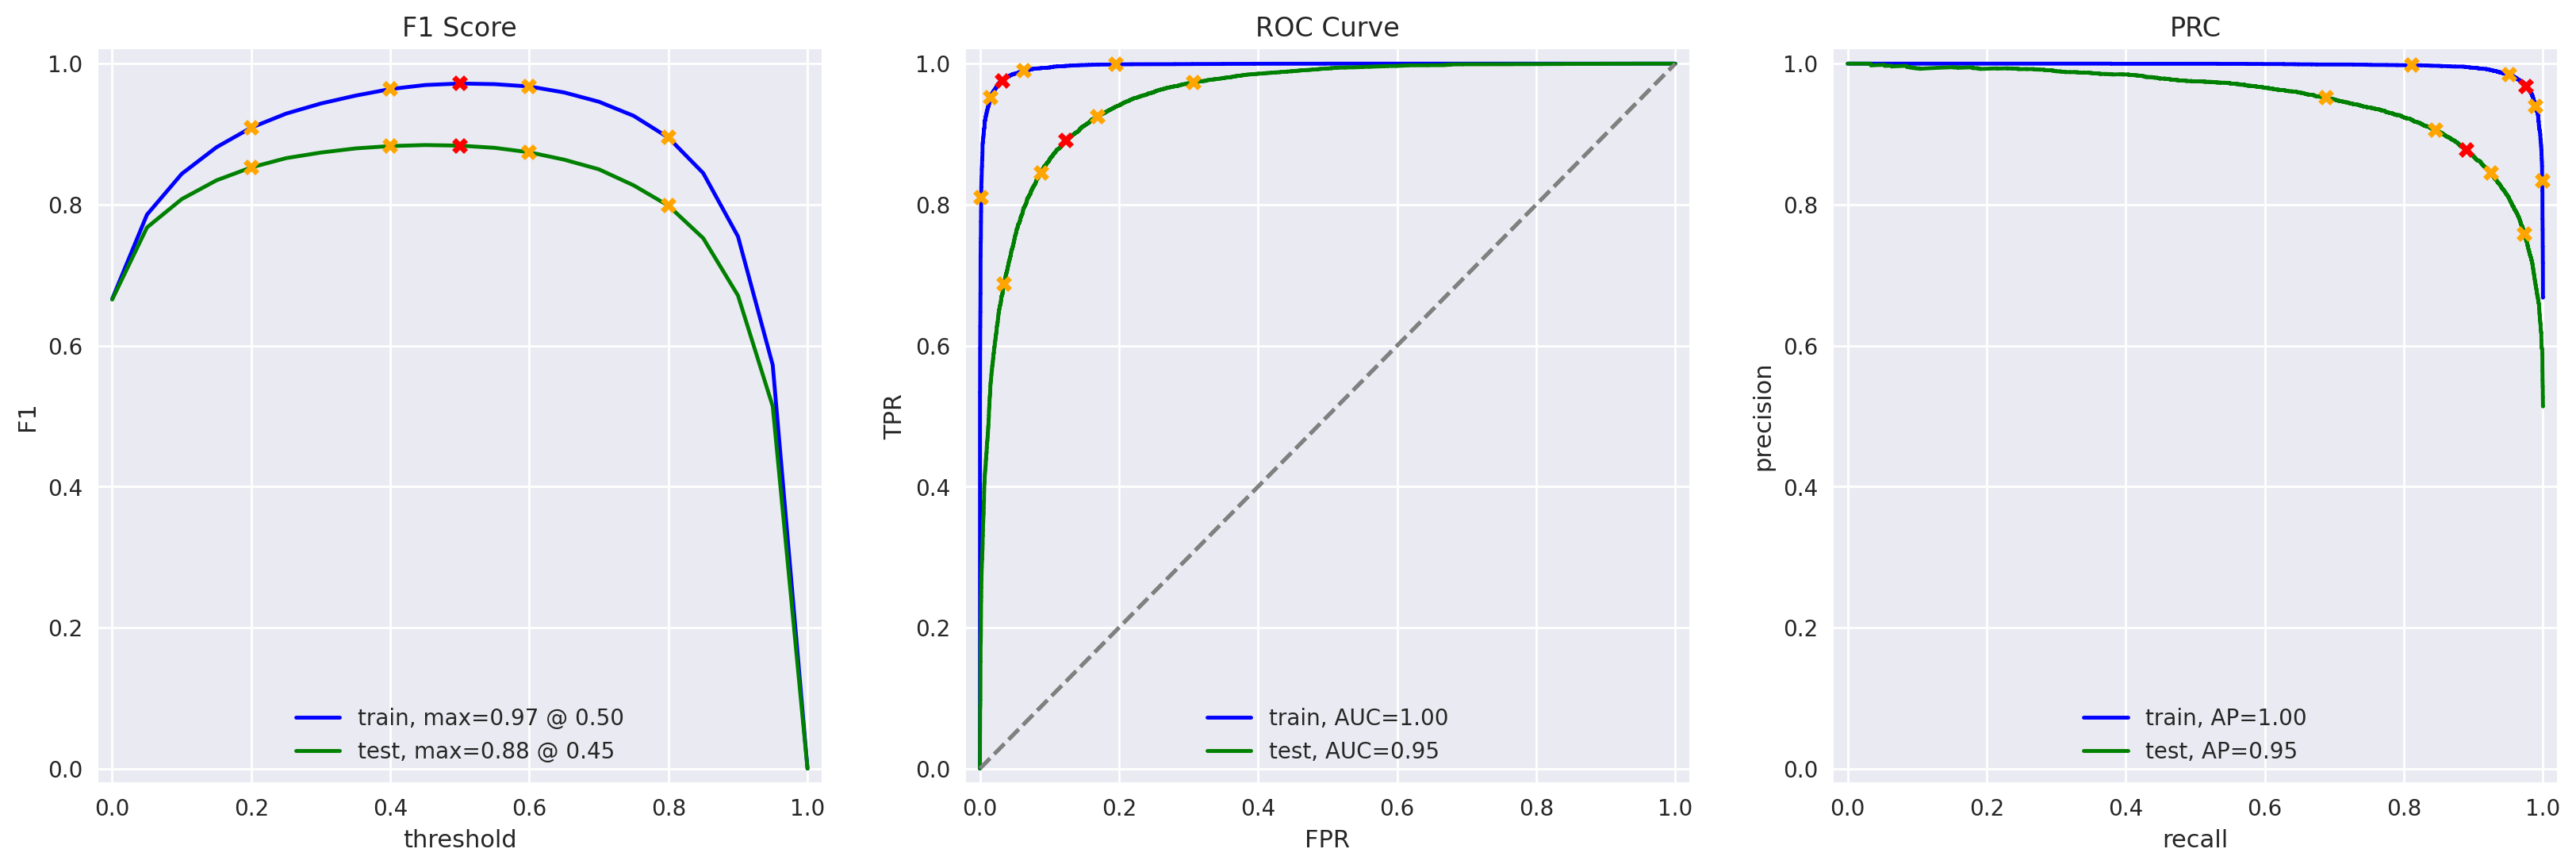

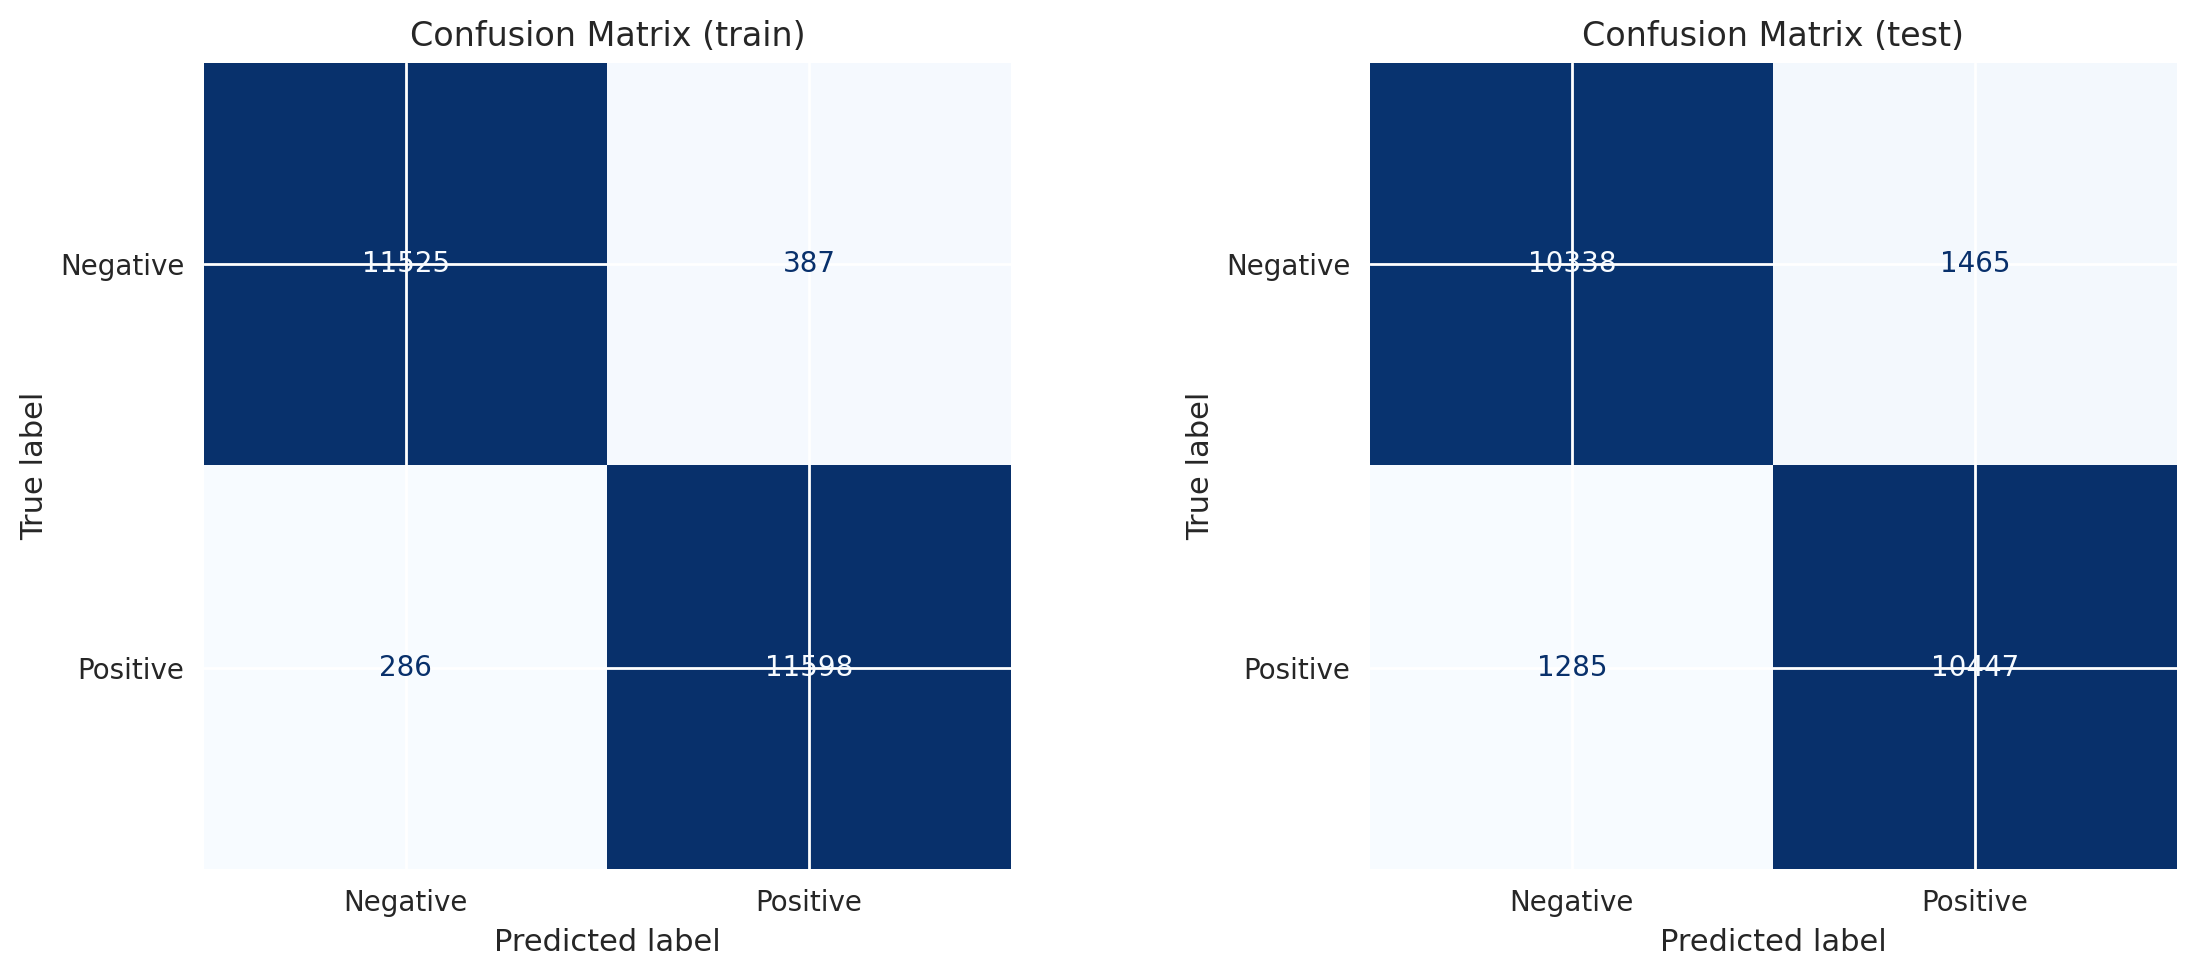

In [25]:
# Reuse preprocessed texts from Model 3
vectorizer_4 = TfidfVectorizer(max_features=20000, ngram_range=(1,2))
train_features_4 = vectorizer_4.fit_transform(train_texts_3)
test_features_4 = vectorizer_4.transform(test_texts_3)

# LightGBM Classifier
model_4 = LGBMClassifier(n_estimators=200, class_weight='balanced')
model_4.fit(train_features_4, train_target)

# Evaluate
evaluate_model(model_4, train_features_4, train_target, test_features_4, test_target)

###  Model 9 - BERT

In [26]:
import torch
import transformers

In [27]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [28]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []
    
    encodings = tokenizer(
        list(texts),
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='pt'
    )
    ids_list = encodings['input_ids']
    attention_mask_list = encodings['attention_mask']
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')
    
# Batch embeddings
    embeddings = []
    for i in tqdm(range(math.ceil(len(ids_list) / batch_size)), disable=disable_progress_bar):
        ids_batch = ids_list[i*batch_size:(i+1)*batch_size].to(device)
        attention_mask_batch = attention_mask_list[i*batch_size:(i+1)*batch_size].to(device)
        
        with torch.no_grad():
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
    
    return np.concatenate(embeddings)

In [29]:
# ⚠️ Warning: slow on CPU — try only a subset if not using GPU
#train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'][:500])
#test_features_9 = BERT_text_to_embeddings(df_reviews_test['review_norm'][:500])

# Classifier on top of BERT embeddings
#model_9 = LogisticRegression(max_iter=200, class_weight='balanced')
#model_9.fit(train_features_9, train_target[:500])

#evaluate_model(model_9, train_features_9, train_target[:500], test_features_9, test_target[:500])

In [30]:
#print(df_reviews_train['review_norm'].shape)
#print(train_features_9.shape)
#print(train_target.shape)

## My Reviews

In [31]:

# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].progress_apply(normalize_text)

my_reviews


  0%|          | 0/8 [00:00<?, ?it/s]

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn t expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...


### Model 2

In [32]:
my_reviews['review_norm'] = my_reviews['review'].progress_apply(normalize_text)

# If Model 2 not explicitly trained, reuse Model 1
tfidf_vectorizer_2 = vectorizer_1
model_2 = model_1

texts = my_reviews['review_norm']
my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_2.transform(texts))[:, 1]

print("\nModel 2 Predictions:")
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}: {review}')

  0%|          | 0/8 [00:00<?, ?it/s]


Model 2 Predictions:
0.26: i did not simply like it not my kind of movie
0.23: well i was bored and felt asleep in the middle of the movie
0.53: i was really fascinated with the movie
0.11: even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.29: i didn t expect the reboot to be so good writers really cared about the source material
0.44: the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.04: what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.85: launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Model 3

In [33]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(
    vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x)))
)[:, 1]

print("\nModel 3 Predictions:")
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}: {review}')


Model 3 Predictions:
0.26: i did not simply like it not my kind of movie
0.20: well i was bored and felt asleep in the middle of the movie
0.50: i was really fascinated with the movie
0.09: even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.22: i didn t expect the reboot to be so good writers really cared about the source material
0.63: the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.06: what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.87: launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Model 4

In [34]:

texts = my_reviews['review_norm']

my_reviews_pred_prob = model_4.predict_proba(
    vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x)))
)[:, 1]

print("\nModel 4 Predictions:")
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}: {review}')


Model 4 Predictions:
0.73: i did not simply like it not my kind of movie
0.47: well i was bored and felt asleep in the middle of the movie
0.64: i was really fascinated with the movie
0.45: even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.44: i didn t expect the reboot to be so good writers really cared about the source material
0.89: the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.25: what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.88: launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Model 9

In [ ]:

texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

print("\nModel 9 Predictions:")
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}: {review}')

## Conclusions

In this project, we built and evaluated multiple models for classifying IMDB reviews into positive and negative sentiments. The steps were carried out in alignment with the project instructions and evaluation criteria.

The IMDB dataset was successfully loaded and inspected.  The reviews were normalized: lowercased, punctuation/digits removed, and extra spaces stripped and exploratory analysis showed the dataset is well balanced between positive and negative reviews in both train and test splits, which supports fair model training and evaluation.  Review distributions across years and per-movie counts were also explored.

We implemented and compared a range of models: 

Model 0 (Dummy Classifier): A constant baseline always predicting the majority class.  As expected, performance was poor (F1 ≈ 0.50), providing a baseline to improve upon.

Model 1 (NLTK stopwords + TF-IDF + Logistic Regression): Achieved strong performance, with F1 > 0.85, satisfying the project’s metric requirement.  TF-IDF captured important word patterns, and Logistic Regression proved effective for linear text separation.

Model 3 (spaCy Lemmatization + TF-IDF + Logistic Regression): Similar to Model 1, but with lemmatization.  Performance was comparable, with small variations. In some cases, lemmatization slightly improved recall, but gains were modest.

Model 4 (spaCy Lemmatization + TF-IDF + LightGBM): Gradient boosting on TF-IDF features achieved competitive results with Logistic Regression.  Performance was strong but training took longer; in some cases, tree-based methods struggled with the high-dimensional TF-IDF space.

Model 9 (BERT embeddings + Logistic Regression): Tested on a smaller subset due to CPU limitations.  It showed promising performance, especially on nuanced reviews. it demonstrated the potential of transformer-based embeddings, though computationally more demanding.

We then tested all models on a set of custom reviews.  Logistic Regression + TF-IDF (Model 1) and LightGBM (Model 4) gave reasonable, interpretable probability scores.   The BERT model (Model 9) often produced sharper distinctions on subtle sentiment but required much more computation.  The results showed that while classical ML models (TF-IDF + LR/GBM) already perform very well, modern deep models like BERT can capture more subtle linguistic cues.

F1 ≥ 0.85 was achieved, meeting the project’s threshold.  Logistic Regression with TF-IDF remains a strong, efficient baseline for sentiment analysis.  Lemmatization (Model 3) offered only marginal improvements compared to raw normalized text.  LightGBM (Model 4) showed competitive performance but added complexity without significant gains.  BERT (Model 9) is powerful but not computationally practical on CPUs for the full dataset.

For practical deployment, Model 1 (TF-IDF + Logistic Regression) is recommended: it is fast, interpretable, and performs very well.  For research or GPU-powered setups, BERT is worth exploring further on the full dataset.

# Checklist

- [x]  Notebook was opened
- [ ]  The text data is loaded and pre-processed for vectorization
- [ ]  The text data is transformed to vectors
- [ ]  Models are trained and tested
- [ ]  The metric's threshold is reached
- [ ]  All the code cells are arranged in the order of their execution
- [ ]  All the code cells can be executed without errors
- [ ]  There are conclusions